In [1]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate
%pip install datasets 


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **0. Import Libraries**


In [11]:
import pandas as pd
import numpy as np
import time
import torch
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import requests


/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **1. Loading the Data and Model**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [12]:
import pandas as pd
train_data = pd.read_csv("./Data/train_data.csv")
test_data = pd.read_csv("./Data/test_data.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

display(train_data.head())
display(test_data.head())

Train size: 2817
Test size: 705


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Zur Vorbereitung sollte man mit einem Arm eine...,3,306,19,27.0,139.0,B2,69.11,B2
1,Es ist ein sehr schöner Abend.,0,531,6,NaN,NaN,A1,99.23,A1
2,Heute führt die Route durch das Gaistal.,1,476,7,10.0,115.0,A2,115.13,A2
3,Als besser verträglich mit dem Leitbild der na...,5,unknown,14,NaN,NaN,C2,31.89,C2
4,Hierzulande liegen sie im Schnitt bei 15. 000 ...,2,483,9,15.0,121.0,B1,87.72,B1


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Es steht an gefährlichen Kreuzungen oder Einmü...,3,638,13,NaN,NaN,B2,49.82,B2
1,1988 entstand in den USA die „International Da...,4,283,24,43.0,150.0,C1,38.66,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",5,unknown,24,NaN,NaN,C2,67.76,C2
3,Architekten können heute keine Bauwerke mehr s...,5,unknown,22,NaN,NaN,C2,57.61,C2
4,60 Prozent verwenden das Taschengeld auch für ...,2,654,10,NaN,NaN,B1,86.71,B1


In [13]:
train_data_reduced = pd.DataFrame()

train_data_reduced["sentence"] = train_data["sentence"]
train_data_reduced["difficulty_label"] = train_data["difficulty_label"]

display(train_data_reduced.head())


test_data_reduced = pd.DataFrame()

test_data_reduced["sentence"] = test_data["sentence"]
test_data_reduced["difficulty_label"] = test_data["difficulty_label"]

display(test_data_reduced.head())

,sentence,difficulty_label
0,Zur Vorbereitung sollte man mit einem Arm eine...,B2
1,Es ist ein sehr schöner Abend.,A1
2,Heute führt die Route durch das Gaistal.,A2
3,Als besser verträglich mit dem Leitbild der na...,C2
4,Hierzulande liegen sie im Schnitt bei 15. 000 ...,B1


,sentence,difficulty_label
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2
1,1988 entstand in den USA die „International Da...,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2
3,Architekten können heute keine Bauwerke mehr s...,C2
4,60 Prozent verwenden das Taschengeld auch für ...,B1


In [7]:
test_data_reduced.to_csv(".//Mistral/test_data.csv", index=False)
train_data_reduced.to_csv("./Mistral/train_data.csv", index=False)

In [3]:
import json
import pandas as pd


# Function to convert DataFrame to JSONL format
def convert_to_jsonl(df, output_file="train_data.jsonl"):
    with open(output_file, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            entry = {
                "messages": [
                    {"role": "system", "content": "Du bist ein Sprachlehrer und Experte für die Klassifizierung von Sätzen nach CEFR-Schwierigkeitsniveaus."},
                    {"role": "user", "content": f"Bitte ordnen Sie diesen Satz einem Schwierigkeitsgrad von A1 bis C2 zu: \"{row['sentence']}\""},
                    {"role": "assistant", "content": row["difficulty_label"]}
                ]
            }
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")


# Convert and save the JSONL file
convert_to_jsonl(train_data_reduced, "train_data.jsonl")
convert_to_jsonl(test_data_reduced, "test_data.jsonl")

# Display the first few lines of the JSONL file for verification
with open("train_data.jsonl", "r", encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline().strip())


{"messages": [{"role": "system", "content": "Du bist ein Sprachlehrer und Experte für die Klassifizierung von Sätzen nach CEFR-Schwierigkeitsniveaus."}, {"role": "user", "content": "Bitte ordnen Sie diesen Satz einem Schwierigkeitsgrad von A1 bis C2 zu: \"Zur Vorbereitung sollte man mit einem Arm eine weit ausholende Bewegung machen, so als wolle man jemanden freudig begrüßen.\""}, {"role": "assistant", "content": "B2"}]}
{"messages": [{"role": "system", "content": "Du bist ein Sprachlehrer und Experte für die Klassifizierung von Sätzen nach CEFR-Schwierigkeitsniveaus."}, {"role": "user", "content": "Bitte ordnen Sie diesen Satz einem Schwierigkeitsgrad von A1 bis C2 zu: \"Es ist ein sehr schöner Abend.\""}, {"role": "assistant", "content": "A1"}]}
{"messages": [{"role": "system", "content": "Du bist ein Sprachlehrer und Experte für die Klassifizierung von Sätzen nach CEFR-Schwierigkeitsniveaus."}, {"role": "user", "content": "Bitte ordnen Sie diesen Satz einem Schwierigkeitsgrad von A

Setup Mistral API Connection

In [ ]:
# Mistral API Key
MISTRAL_API_KEY = ""

# Mistral API Endpoint
MISTRAL_API_URL = "https://api.mistral.ai/v1/chat/completions"

# Define Model Names
BASELINE_MODEL ="open-mistral-nemo"
FINETUNED_MODEL = "ft:open-mistral-7b:52509ba7:20250209:f4a76503"  # Your fine-tuned model ID




### **4. Define the Mistral 7B Query Function**

This function calls Mistral 7B to classify the sentence into CEFR levels.

In [103]:
# Define prompt template


# Define Prompt Template
PROMPT_TEMPLATE = """ 
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text that is in german, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{}"
"""

def query_mistral(sentence, model_name):
    """
    Queries the Mistral API to classify a sentence into CEFR levels.

    :param sentence: The German sentence to classify.
    :param model_name: The model to use ("mistral-small" or fine-tuned model ID).
    :return: The predicted CEFR level (A1 to C2) or None in case of an error.
    """
    prompt = PROMPT_TEMPLATE.format(sentence)

    headers = {
        "Authorization": f"Bearer {MISTRAL_API_KEY}",
        "Content-Type": "application/json",
    }

    data = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": "You are a CEFR language proficiency classifier."},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0.0,  # Ensures deterministic results
        "max_tokens": 2,  # We only need the CEFR level
    }

    try:
        response = requests.post(MISTRAL_API_URL, headers=headers, json=data)
        response.raise_for_status()  # Raise an error if the request fails
        result = response.json()
        
        return result["choices"][0]["message"]["content"].strip()
    
    except requests.exceptions.RequestException as e:
        print(f"API Error ({model_name}): {e}")
        return None





Test of the function that predict level.

In [104]:
# Print the row of true level A1
print(train_data_reduced[train_data_reduced["difficulty_label"] == "A1"].iloc[0])

sentence            Es ist ein sehr schöner Abend.
difficulty_label                                A1
Name: 1, dtype: object


In [106]:
# Test sentence
test_sentence = "Es ist ein sehr schöner Abend."


# Get predictions from both models
baseline_prediction = query_mistral(test_sentence, BASELINE_MODEL)
finetuned_prediction = query_mistral(test_sentence, FINETUNED_MODEL)

# Print the results
print(f"Sentence: {test_sentence}")
print(f"Baseline Model ({BASELINE_MODEL}) Prediction: {baseline_prediction}")
time.sleep(1)  # Sleep for 1 second to avoid rate limiting
print(f"Fine-Tuned Model Prediction: {finetuned_prediction}")

Sentence: Es ist ein sehr schöner Abend.
Baseline Model (open-mistral-nemo) Prediction: B1
Fine-Tuned Model Prediction: A1


In [115]:
# get sample of test data
#sample_test_data = test_data.sample(30)
sample_test_data = test_data
display(sample_test_data)

,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Es steht an gefährlichen Kreuzungen oder Einmü...,3,638,13,NaN,NaN,B2,49.82,B2
1,1988 entstand in den USA die „International Da...,4,283,24,43.0,150.0,C1,38.66,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",5,unknown,24,NaN,NaN,C2,67.76,C2
3,Architekten können heute keine Bauwerke mehr s...,5,unknown,22,NaN,NaN,C2,57.61,C2
4,60 Prozent verwenden das Taschengeld auch für ...,2,654,10,NaN,NaN,B1,86.71,B1
...,...,...,...,...,...,...,...,...,...
700,Es gibt auch Begriffe aus der gesprochenen Spr...,3,690,13,NaN,NaN,B2,75.20,B2
701,Inzwischen sind die Menschen aber bestens info...,4,315,20,31.0,143.0,C1,51.18,C1
702,Nur rund 14 Prozent ihres Einkommens gaben sie...,2,315,14,21.0,128.0,B1,91.11,B1
703,In meiner ersten Woche habe ich drei Teller fa...,1,529,10,NaN,NaN,A2,78.25,A2


In [116]:

# Create a DataFrame to store predictions
results = []
id = 0

# Iterate over the test dataset
for idx, row in sample_test_data.iterrows():
    sentence = row["sentence"]
    y_true = row["difficulty_label"]
    
    print(f"Processing sentence {id + 1}/{len(sample_test_data)}: {sentence}")

    finetuned_pred = query_mistral(sentence, FINETUNED_MODEL)
    time.sleep(2)  # Delay between API calls

    # Store results
    results.append({
        "sentence": sentence,
        "true_difficulty": y_true,
        "mistral_finetuned_prediction": finetuned_pred
    })

    id += 1

# Convert results to DataFrame and save
df_results = pd.DataFrame(results)

# Display the results
display(df_results)


Processing sentence 1/705: Es steht an gefährlichen Kreuzungen oder Einmündungen, an denen leicht Unfälle passieren können.
Processing sentence 2/705: 1988 entstand in den USA die „International Dark Sky Association“ (IDA), eine Vereinigung von Astronomen, die aktiv über „Lichtverschmutzung“ aufklärt und gegen sie kämpft.
Processing sentence 3/705: Die Denkweise, Häuser als Maschinen, in denen Menschen leben, zu verstehen, wie es einmal ein Architekt des 20. Jahrhunderts ausgedrückt hat, hat fatale Auswirkungen.
Processing sentence 4/705: Architekten können heute keine Bauwerke mehr schaffen wie das Bremer Rathaus, das über Jahrhunderte hinweg ein Symbol der Bürgerschaft war und ist.
Processing sentence 5/705: 60 Prozent verwenden das Taschengeld auch für Zeitschriften oder Comics.
Processing sentence 6/705: Eine Jury wählte dann 15. 000 Gewinner aus – alle genau 18 Jahre alt und EU-Bürger.
Processing sentence 7/705: Aber die Frauen besannen sich auf das Erbe der beiden Käsepioniere.
P

,sentence,true_difficulty,mistral_finetuned_prediction
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2,B2
1,1988 entstand in den USA die „International Da...,C1,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2,C2
3,Architekten können heute keine Bauwerke mehr s...,C2,C2
4,60 Prozent verwenden das Taschengeld auch für ...,B1,B1
...,...,...,...
700,Es gibt auch Begriffe aus der gesprochenen Spr...,B2,C1
701,Inzwischen sind die Menschen aber bestens info...,C1,B2
702,Nur rund 14 Prozent ihres Einkommens gaben sie...,B1,B1
703,In meiner ersten Woche habe ich drei Teller fa...,A2,A2


In [117]:

#Print classification report
from sklearn.metrics import classification_report



# Extract the true and predicted labels
y_true = df_results["true_difficulty"]

y_finetuned_pred = df_results["mistral_finetuned_prediction"]


# Print the classification report for the fine-tuned model
print("Mistral-7B Classification Report:")
print(classification_report(y_true, y_finetuned_pred))


Mistral-7B Classification Report:
              precision    recall  f1-score   support

          A1       0.94      0.42      0.58       117
          A2       0.48      0.41      0.44       117
          B1       0.41      0.53      0.46       118
          B2       0.42      0.69      0.52       118
          C1       0.52      0.38      0.44       118
          C2       0.71      0.72      0.71       117

    accuracy                           0.53       705
   macro avg       0.58      0.53      0.53       705
weighted avg       0.58      0.53      0.53       705



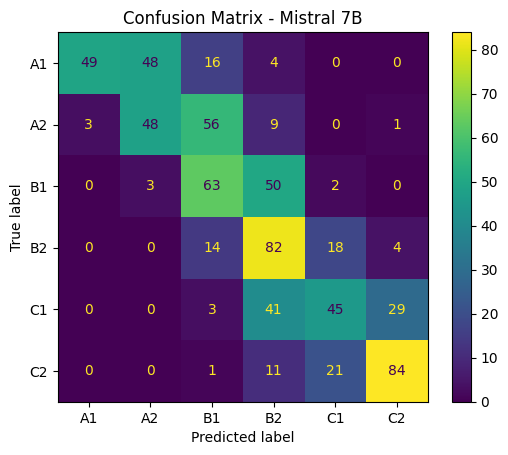

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CEFR Mapping (A1=0, A2=1, ..., C2=5)
cefr_mapping = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}
labels = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Convert true labels to numerical format
y_true_numeric = df_results["true_difficulty"].map(cefr_mapping).tolist()

# Convert predictions to numeric format
y_pred_numeric = df_results["mistral_finetuned_prediction"].map(cefr_mapping).tolist()

# Filter out invalid predictions
valid_indices = [i for i in range(len(y_pred_numeric)) if y_pred_numeric[i] is not None]
y_true_filtered = [y_true_numeric[i] for i in valid_indices]
y_pred_filtered = [y_pred_numeric[i] for i in valid_indices]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered, labels=range(6))

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap="viridis")
plt.title(f"Confusion Matrix - Mistral 7B")
plt.show()


### Pairewise Mismmatch metric
The pairwise mismatch metric focuses on computing ordering violations in predictions relative to ground truth.
<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">

In [119]:
from sklearn.preprocessing import LabelEncoder

def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> float:
    """
    Compute the pairwise mismatch metric.
    
    :param y_pred: Pandas Series of predicted difficulty levels
    :param y_real: Pandas Series of true difficulty levels
    :return: Mean pairwise mismatch score
    """
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically by real and predicted labels
    predictions = predictions.sort_values(by=["real", "pred"])

    # Convert categorical labels into numeric values while keeping order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialize LabelEncoder and encode labels
    label_encoder = LabelEncoder()
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)

    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()

# Compute pairwise mismatch for Mistral-7B



mismatch_score = pairwise_mismatch(y_true_filtered, y_pred_filtered)
print(f"Pairwise Mismatch Score (Mistral-7B-finetuned): {mismatch_score:.4f}")


Pairwise Mismatch Score (Mistral-7B-finetuned): 21.6057
